# This is the final project of Machine Learning
### Transfer Learning for Image Classification
#### William Lu
#### 7424831487
#### WilliamLu1999

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import glob
import os
import math
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [58]:
import tensorflow as tf

In [59]:
from tensorflow import keras

In [60]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2 as cv
import splitfolders
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Dropout

#### (b)i,ii spliting the data in to training, validation, and testing. 

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
splitfolders.ratio("/content/drive/My Drive/final-project-WilliamLu1999/images", output="/content/drive/My Drive/final-project-WilliamLu1999/output", seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False)
print('done')


Copying files: 1148 files [20:59,  1.17s/ files]
Copying files: 1149 files [21:01,  1.15s/ files]
Copying files: 1150 files [21:02,  1.15s/ files]
Copying files: 1151 files [21:03,  1.14s/ files]
Copying files: 1152 files [21:04,  1.15s/ files]
Copying files: 1153 files [21:05,  1.17s/ files]
Copying files: 1154 files [21:06,  1.16s/ files]
Copying files: 1155 files [21:07,  1.15s/ files]
Copying files: 1156 files [21:09,  1.14s/ files]
Copying files: 1157 files [21:10,  1.15s/ files]
Copying files: 1158 files [21:11,  1.15s/ files]
Copying files: 1159 files [21:12,  1.14s/ files]
Copying files: 1160 files [21:13,  1.15s/ files]
Copying files: 1161 files [21:14,  1.15s/ files]
Copying files: 1162 files [21:15,  1.14s/ files]
Copying files: 1163 files [21:17,  1.16s/ files]
Copying files: 1164 files [21:18,  1.16s/ files]
Copying files: 1165 files [21:19,  1.17s/ files]
Copying files: 1166 files [21:20,  1.16s/ files]
Copying files: 1167 files [21:21,  1.15s/ files]
Copying files: 1168

done


Now all images are in the right path. Since we use ceilings to determine the number of images

#### (b)iii resize images and one hot encoding by applying 'categorical' to label_mode.

#### (c) ii Perform empirical regularization, crop, randomly zoo, rotate, ip, contrast, and translate images in your training set for image augmentation.

#### Both done in the same part at below.

reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [61]:
from keras.applications.vgg16 import VGG16, preprocess_input
image_width, image_height = 224,224 # resize

train_datagen = ImageDataGenerator(
      #rescale=1./255, 
      rotation_range=40, # rotate
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,# randomly zoom
      horizontal_flip=True,vertical_flip=True, # flip
      fill_mode='nearest',brightness_range=(0.1, 0.9) #contrast
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)# resize (b)ii

train_generator = train_datagen.flow_from_directory(
                    "/content/drive/My Drive/final-project-WilliamLu1999/output/train/",
                    batch_size=5,
                    class_mode='categorical', # one hot encoding
                    target_size=(image_width, image_height),
                    keep_aspect_ratio=True # crop
)

# not performing image augmentation on validation and testing data
validation_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/final-project-WilliamLu1999/output/val/',
        target_size=(image_width, image_height),
        batch_size=5,
        shuffle=False,
        class_mode='categorical')

print('success')

Found 820 images belonging to 20 classes.
Found 171 images belonging to 20 classes.
success


#### (c) iii Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss
reference: https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9

In [62]:
pre_trained_vgg16 = VGG16(
    input_shape=(image_width,image_height,3),
    include_top=False, #no weights will be downloaded for dense layers
    weights="imagenet"
)

for layer in pre_trained_vgg16.layers:
    layer.trainable=False
    
pre_trained_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [63]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Softmax

vgg_16_model = tf.keras.models.Sequential([
    pre_trained_vgg16,
    Dropout(0.2), # dropout of 20%
    Flatten(),
    Dense(256,activation="relu"),    
    #Dense(256,activation="relu"),
    BatchNormalization(),
    #Dropout(0.2), # dropout of 20%
    Dense(20, activation='softmax'), # 20 classes
    Softmax()
])

In [64]:
vgg_16_model.compile(
            optimizer="adam",
            loss='categorical_crossentropy',
            metrics = ['accuracy']
)
vgg_16_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               6422784   
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 20)                5140      
                                                      

In [65]:
# early stopping
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=50, verbose=0, mode='auto')

In [66]:
# fit generator
first = vgg_16_model.fit_generator(generator= train_generator, epochs= 100, 
                          validation_data= validation_generator,callbacks=[early])

Epoch 1/100


<ipython-input-66-77958f5ec5fc>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  first = vgg_16_model.fit_generator(generator= train_generator, epochs= 100,


164/164 [==============================] - 16s 94ms/step - loss: 2.9241 - accuracy: 0.1549 - val_loss: 2.8351 - val_accuracy: 0.2398
Epoch 2/100
164/164 [==============================] - 15s 93ms/step - loss: 2.8329 - accuracy: 0.2780 - val_loss: 2.7512 - val_accuracy: 0.3275
Epoch 3/100
164/164 [==============================] - 15s 92ms/step - loss: 2.7436 - accuracy: 0.3939 - val_loss: 2.6878 - val_accuracy: 0.3743
Epoch 4/100
164/164 [==============================] - 15s 92ms/step - loss: 2.6895 - accuracy: 0.4293 - val_loss: 2.6181 - val_accuracy: 0.4795
Epoch 5/100
164/164 [==============================] - 15s 91ms/step - loss: 2.6728 - accuracy: 0.4512 - val_loss: 2.5889 - val_accuracy: 0.4854
Epoch 6/100
164/164 [==============================] - 15s 91ms/step - loss: 2.6442 - accuracy: 0.4854 - val_loss: 2.6009 - val_accuracy: 0.4912
Epoch 7/100
164/164 [==============================] - 15s 92ms/step - loss: 2.5996 - accuracy: 0.5390 - val_loss: 2.5789 - val_accuracy: 0.51

Text(0.5, 1.0, 'Training and validation loss')

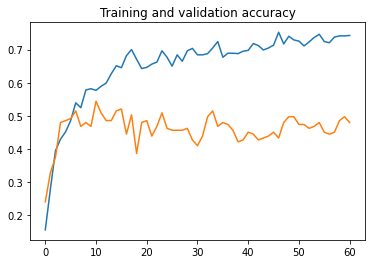

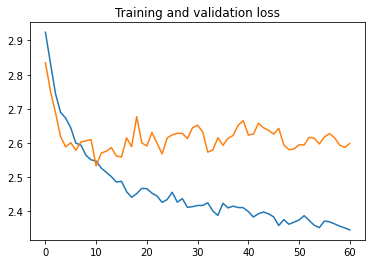

In [67]:
import matplotlib.pyplot as plt

acc      = first.history['accuracy']
val_acc  = first.history['val_accuracy']
loss     = first.history['loss']
val_loss = first.history['val_loss']

epochs   = range(len(acc))


# Plot training and validation accuracy per epoch
plt.plot(epochs,acc)
plt.plot(epochs,val_acc)
plt.title('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.title('Training and validation loss')

In [68]:
vgg_16_model.save_weights("vgg_16_model.h5")

In [69]:
test_generator = test_datagen.flow_from_directory(
                    "/content/drive/My Drive/final-project-WilliamLu1999/output/test/",
                    batch_size=5, 
                    class_mode='categorical', # set to None maybe?
                    shuffle=False,
                    target_size=(image_width, image_height)
)

Found 185 images belonging to 20 classes.


In [70]:
pred = vgg_16_model.predict_generator(test_generator,verbose=1)

<ipython-input-70-2e6aaf6931f6>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = vgg_16_model.predict_generator(test_generator,verbose=1)


37/37 [==============================] - 1s 30ms/step


In [71]:
predIdxs = np.argmax(pred, axis=1)
from sklearn.metrics import classification_report
print(classification_report(test_generator.labels, predIdxs,target_names=['class '+str(i) for i in range(0,20)]))

              precision    recall  f1-score   support

     class 0       1.00      0.38      0.55         8
     class 1       0.83      0.56      0.67         9
     class 2       0.13      0.70      0.23        10
     class 3       0.70      0.70      0.70        10
     class 4       0.80      0.44      0.57         9
     class 5       0.50      0.22      0.31         9
     class 6       0.89      0.89      0.89         9
     class 7       0.64      0.78      0.70         9
     class 8       0.55      0.67      0.60         9
     class 9       0.80      0.89      0.84         9
    class 10       0.44      0.44      0.44         9
    class 11       0.86      0.67      0.75         9
    class 12       1.00      0.22      0.36         9
    class 13       0.75      0.67      0.71         9
    class 14       0.71      0.56      0.63         9
    class 15       1.00      0.30      0.46        10
    class 16       0.91      1.00      0.95        10
    class 17       0.29    

In [72]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
pre_trained_ENB = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(image_width, image_height, 3))

In [73]:
for layer in pre_trained_ENB.layers:
    layer.trainable=False

In [74]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Softmax

ENB_model = tf.keras.models.Sequential([
    pre_trained_ENB,
    Dropout(0.2), # dropout of 20%
    Flatten(),
    Dense(256,activation="relu"),    
    #Dense(256,activation="relu"),
    BatchNormalization(),
    #Dropout(0.2), # dropout of 20%
    Dense(20, activation='softmax'), # 20 classes
    Softmax()
])

In [75]:
ENB_model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [79]:
ENB_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 flatten_5 (Flatten)         (None, 62720)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               16056576  
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 20)                5140      
                                                      

In [80]:
datagen_2 = ImageDataGenerator(
      rotation_range=40, # rotate
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,# randomly zoom
      horizontal_flip=True,vertical_flip=True, # flip
      fill_mode='nearest',brightness_range=(0.1, 0.9) #contrast
)
test_datagen_2 = ImageDataGenerator()

train_generator_2 = datagen_2.flow_from_directory(
    "/content/drive/My Drive/final-project-WilliamLu1999/output/train/",
        target_size=(image_width, image_height),
        keep_aspect_ratio=True, # crop
        batch_size=5,
        class_mode='categorical',
        shuffle=True
)

val_generator_2 = test_datagen_2.flow_from_directory(
    '/content/drive/My Drive/final-project-WilliamLu1999/output/val/',
        target_size=(image_width, image_height),
        batch_size=5,
        class_mode='categorical',
        shuffle=False
)

print('success')

Found 820 images belonging to 20 classes.
Found 171 images belonging to 20 classes.
success


In [81]:
second = ENB_model.fit_generator(generator= train_generator_2, epochs= 100, 
                          validation_data= val_generator_2,callbacks=[early])

Epoch 1/100


<ipython-input-81-9d534c2459a7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  second = ENB_model.fit_generator(generator= train_generator_2, epochs= 100,


164/164 [==============================] - 22s 100ms/step - loss: 2.8891 - accuracy: 0.2037 - val_loss: 2.7411 - val_accuracy: 0.3333
Epoch 2/100
164/164 [==============================] - 15s 93ms/step - loss: 2.7253 - accuracy: 0.3671 - val_loss: 2.4868 - val_accuracy: 0.5965
Epoch 3/100
164/164 [==============================] - 15s 92ms/step - loss: 2.6329 - accuracy: 0.4841 - val_loss: 2.4971 - val_accuracy: 0.5906
Epoch 4/100
164/164 [==============================] - 15s 92ms/step - loss: 2.5535 - accuracy: 0.5573 - val_loss: 2.4550 - val_accuracy: 0.6199
Epoch 5/100
164/164 [==============================] - 15s 93ms/step - loss: 2.5463 - accuracy: 0.5549 - val_loss: 2.3864 - val_accuracy: 0.7018
Epoch 6/100
164/164 [==============================] - 15s 92ms/step - loss: 2.4838 - accuracy: 0.6207 - val_loss: 2.3120 - val_accuracy: 0.8070
Epoch 7/100
164/164 [==============================] - 15s 92ms/step - loss: 2.4626 - accuracy: 0.6378 - val_loss: 2.3129 - val_accuracy: 0.7

Text(0.5, 1.0, 'Training and validation loss')

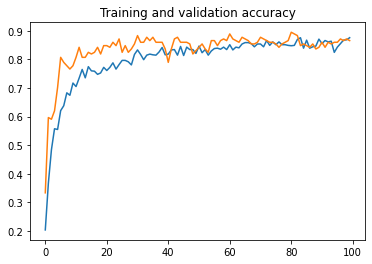

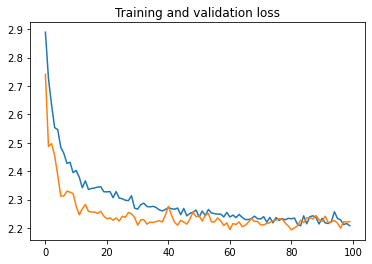

In [82]:
acc2 = second.history['accuracy']
val_acc2 = second.history['val_accuracy']
loss2 = second.history['loss']
val_loss2 = second.history['val_loss']

epochs2 = range(len(acc2))


# Plot training and validation accuracy per epoch
plt.plot(epochs2,acc2)
plt.plot(epochs2,val_acc2)
plt.title('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs2,loss2)
plt.plot(epochs2,val_loss2)
plt.title('Training and validation loss')

In [83]:
ENB_model.save("ENB_model.h5")

In [84]:
test_generator_2 = test_datagen_2.flow_from_directory(
                    "/content/drive/My Drive/final-project-WilliamLu1999/output/test/",
                    batch_size=5, 
                    class_mode='categorical', 
                    shuffle=False,
                    target_size=(image_width, image_height)
)

Found 185 images belonging to 20 classes.


In [85]:
pred_2 = ENB_model.predict_generator(test_generator_2,verbose=1)

<ipython-input-85-905d4553c814>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_2 = ENB_model.predict_generator(test_generator_2,verbose=1)


37/37 [==============================] - 3s 30ms/step


In [86]:
predIdxs_2 = np.argmax(pred_2, axis=1)
print(classification_report(test_generator_2.labels, predIdxs_2,target_names=['class '+str(i) for i in range(0,20)]))

              precision    recall  f1-score   support

     class 0       0.88      0.88      0.88         8
     class 1       1.00      0.89      0.94         9
     class 2       1.00      1.00      1.00        10
     class 3       1.00      0.80      0.89        10
     class 4       1.00      0.67      0.80         9
     class 5       0.88      0.78      0.82         9
     class 6       1.00      1.00      1.00         9
     class 7       0.82      1.00      0.90         9
     class 8       1.00      1.00      1.00         9
     class 9       0.90      1.00      0.95         9
    class 10       1.00      1.00      1.00         9
    class 11       0.82      1.00      0.90         9
    class 12       1.00      0.89      0.94         9
    class 13       0.75      0.67      0.71         9
    class 14       0.73      0.89      0.80         9
    class 15       0.70      0.70      0.70        10
    class 16       1.00      1.00      1.00        10
    class 17       1.00    